# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [2]:
!pip install seaborn==0.9.0

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [4]:
labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
         'married', 'job', 'relationship', 'race', 'sex', 'capital_gain', 
         'capital_loss', 'hours_per_week', 'native_country', 'salary']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
           names = labels)

df.head()

,age,workclass,fnlwgt,education,education_num,married,job,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df.shape

(32561, 15)

In [6]:
df.salary.unique()

array([' <=50K', ' >50K'], dtype=object)

In [0]:
df = df[(df.astype(str) != '?').all(axis=1)]
df = df.replace({'?': np.nan}).dropna()

In [0]:
le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

In [9]:
df_encoded.head()

,age,workclass,fnlwgt,education,education_num,married,job,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,22,7,2671,9,12,4,1,1,4,1,25,0,39,39,0
1,33,6,2926,9,12,2,4,0,4,1,0,0,12,39,0
2,21,4,14086,11,8,0,6,1,4,1,0,0,39,39,0
3,36,4,15336,1,6,2,6,0,2,1,0,0,39,39,0
4,11,4,19355,9,12,2,10,5,2,0,0,0,39,5,0


## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

In [10]:
X = df_encoded.drop(['salary'], axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


y = df_encoded['salary']
clf = LogisticRegression(random_state=42, solver='lbfgs',
                        multi_class='multinomial', max_iter=1000).fit(X, y)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
sns.set(rc={'figure.figsize':(12,6)})

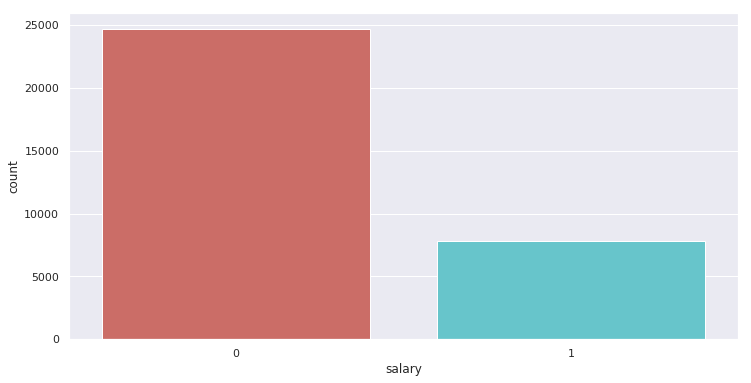

In [28]:
sns.countplot(x='salary',data=df_encoded, palette='hls')
plt.show();

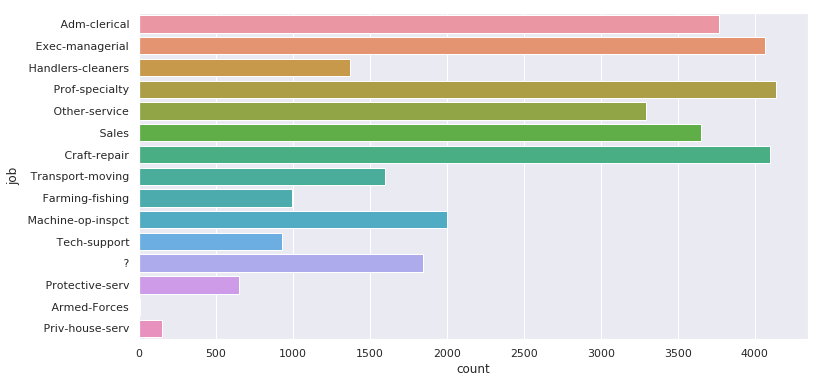

In [29]:
sns.countplot(y="job", data=df)
plt.show()

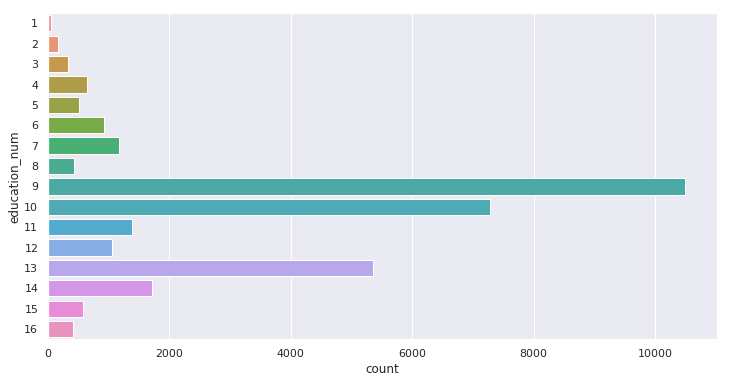

In [46]:
sns.countplot(y="education_num", data=df)
plt.show()

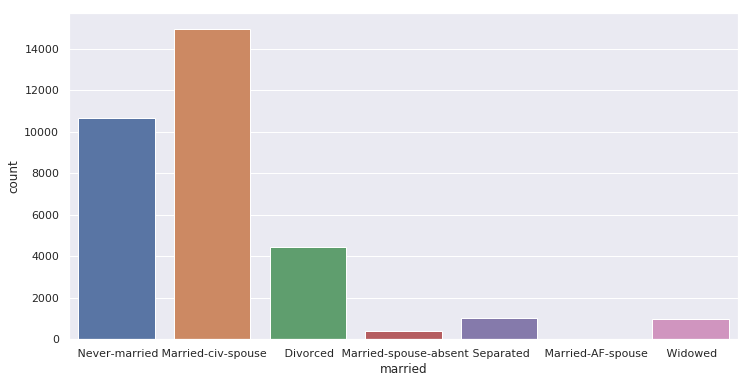

In [30]:
sns.countplot(x="married", data=df)
plt.show()

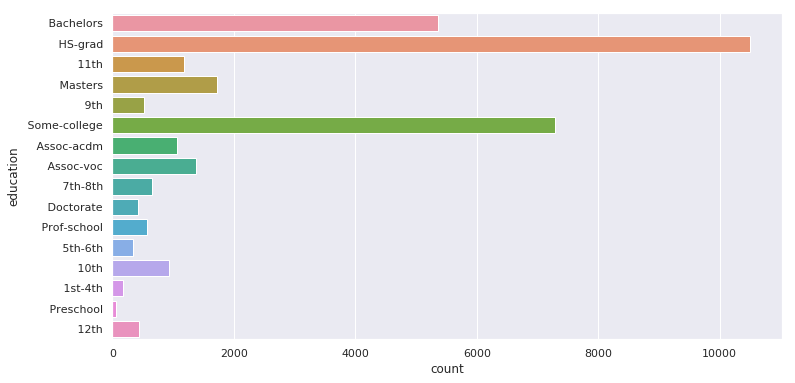

In [47]:
sns.countplot(y="education", data=df)
plt.show()

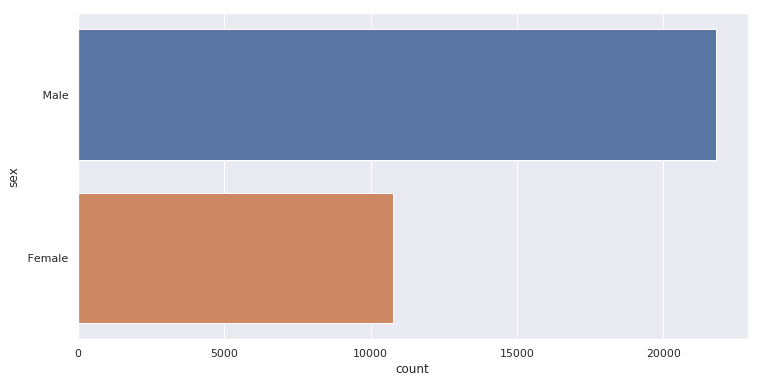

In [66]:
sns.countplot(y="sex", data=df)
plt.show()

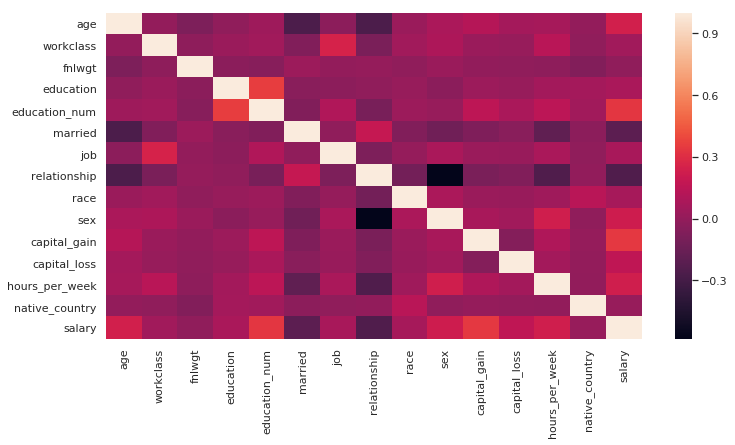

In [31]:
sns.heatmap(df_encoded.corr())
plt.show()

In [15]:
clf.score(X, y)

0.8237154878535672

In [16]:
label_coef = clf.coef_.tolist()
x = 0
for coef in label_coef[0]:
  print('The coefficient for', labels[x], 'is ', label_coef[0][x])
  x = x + 1

The coefficient for age is  1.2317603990095087
The coefficient for workclass is  -0.0794798950287589
The coefficient for fnlwgt is  0.09147052187250813
The coefficient for education is  0.11924750357170082
The coefficient for education_num is  2.4839730126984274
The coefficient for married is  -0.6889981780049484
The coefficient for job is  0.07211989538648847
The coefficient for relationship is  -0.283557118190277
The coefficient for race is  0.21321841084417434
The coefficient for sex is  0.4382528677145356
The coefficient for capital_gain is  1.6279143019442546
The coefficient for capital_loss is  1.3149635466935585
The coefficient for hours_per_week is  1.4403278865816391
The coefficient for native_country is  0.06672305766519114


# Coefficients

The interpretation here is that for every 1 unit increase, the positive coefs increase the log-odds of salary by their specified value, and as a result the probability of having a salary greater than 50K increases, while negative coefs have the inverse effect. 

In [17]:
print('Intercept for model is ', clf.intercept_)

Intercept for model is  [-3.72437872]


In [18]:
logodds = clf.intercept_
odds = np.exp(logodds)
prob = odds/(1 + odds)
prob

array([0.02355964])

# Interpreting the intercept

The likelyhood of having a salary greater than 50K if all features are 0 is pretty low. Which makes sense. You wouldn't expect a newborn child with no education, assets, or job to have a salary period :P 

#  Just curious... O,O

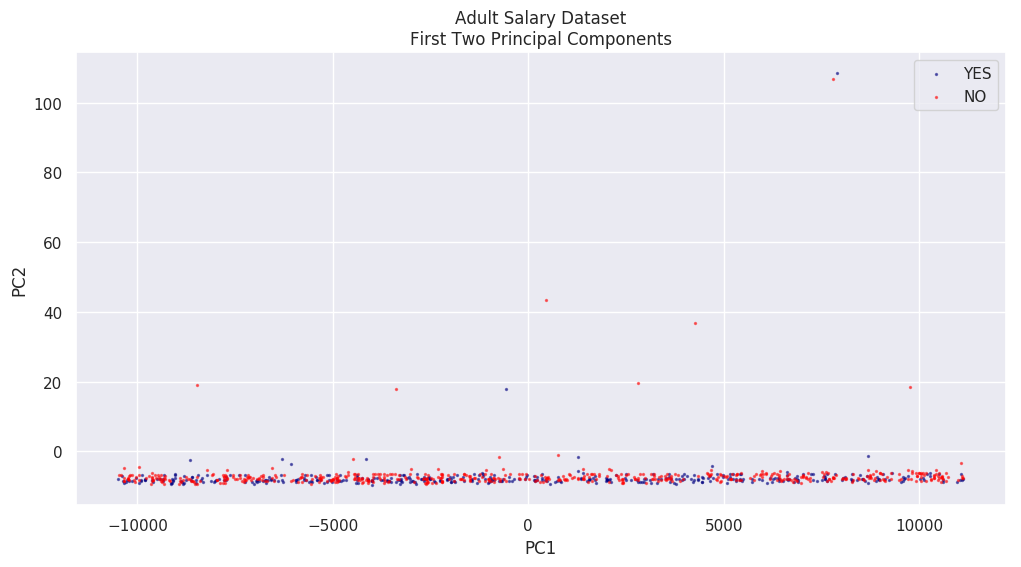

In [43]:

X_pca = df_encoded.iloc[:,1:]
y_pca = df_encoded.iloc[:,0]
pca = PCA(n_components=2).fit_transform(X_pca)
X_train, X_test, y_train, y_test = train_test_split(pca, y_pca, random_state=42)

plt.figure(dpi=100)
plt.scatter(pca[y_pca.values==0,0], pca[y_pca.values==0,1], alpha=0.5, label='YES', s=2, color='navy')
plt.scatter(pca[y_pca.values==1,0], pca[y_pca.values==1,1], alpha=0.5, label='NO', s=2, color='red')
plt.legend()
plt.title('Adult Salary Dataset\nFirst Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Predictions for functional logistic regression

$f(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \cdots + \beta_k x_k)}}$

In [65]:

# set option to see entire np array
np.set_printoptions(threshold=np.nan)
clf.predict_proba(X)[1:10]

array([[0.71365984, 0.28634016],
       [0.78243452, 0.21756548],
       [0.89441279, 0.10558721],
       [0.91346925, 0.08653075],
       [0.80562623, 0.19437377],
       [0.99266922, 0.00733078],
       [0.74196591, 0.25803409],
       [0.18280114, 0.81719886],
       [0.12835001, 0.87164999]])

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k? 
2. What are 3 features negatively correlated with income above 50k? 
3. Overall, how well does the model explain the data and what insights do you derive from it?

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

Approaches:
1. Ridge Regression
2. Quantile Regression
3. Survival Analysis

# Scales data. Finds interpreting coeffecients harder.

![alt text](https://gonintendo.com/system/file_uploads/uploads/000/052/819/original/pikachu_sorprendido.jpg)

# 1. What are 3 features positively correlated with income above 50k? 
Age, hours per week, education
# 2. What are 3 features negatively correlated with income above 50k? 
Relationship, marriage, workclass
# 3. Overall, how well does the model explain the data and what insights do you derive from it?
Our score for the model is .82, which is reasonable, however, I do notice the data tends to be skewed in certain instances, such as variance in occupation(and a large subset of occupations missing period, so it's not quite representative of the population in my opinion) Because we scaled all of our features, the intepretation of the coeffecients is a bit harder. We can say with surety that given the data, we know which coeffecients  cause a negative or positive increase to the target, but we're unsure what the unit increase is after scaling. But that's okay. We're not looking for precise metrics, we want to build a model that makes accurate predictions given our attributes.  

There is also an immense amount of non-college graduates in our dataset, which may explain why we have a negative coeffecient for education, while the education num coeff is highly positive. The only explanation for this is that education num is not representative of the years spent in education, but is simply an ordinal variable.

I believe the ? marks represent unemployment rather than an associated job, and so while I decided to keep them in because I cannot verify, I do wonder if it has an impact on occupation's coef.

# Enough chatter, explain.
In a nutshell, the two most highest indicators of income >50k that in my own personal opinion can be validated (capital gain/loss is a bit on the meh side) are an increased age(and propbably workforce tenure) and the amount of hours worked. I mean, duh. More hours = more money. Especially considering the majority of our occupaction variance lies with non-salaried employees.



1.**You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.** Quantile regression for the win! We want to explain the variance of a subclass of the population, and we likely expect the features affecting these at risk students to have variable slopes. There are multiple factors that could contribute to at risk, such as income, abusive household, etc. We need to look specifically at our chosen ones and identify their feature contributions, not the student body as a whole.

2.**You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched**. Seems weird to call it survival analysis here, but ultimately we want to predict the time to an event with the model, so it's highly appropriate. We know there will be a finite period of time, and we have censored data hopefully for their prior released products and failed products that we can use to model with.

3.**You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.**
Well, that leafs us with some planty data that needs ridge regression. I mean hello, we have a ton of features, but not enough observations, because we only have a few dozen plants. Also we might expect physical data to be highly correlated, so it's a remedial countermeasure. Aka accounts for the above and reduces complexity. Nuff said.